In [11]:
import warnings
warnings.filterwarnings('ignore')

Automatically created module for IPython interactive environment
Time for KRR fitting: 29.097
Time for GPR fitting: 0.312
Time for KRR prediction: 0.163
Time for GPR prediction: 0.166
Time for GPR prediction with standard-deviation: 0.197


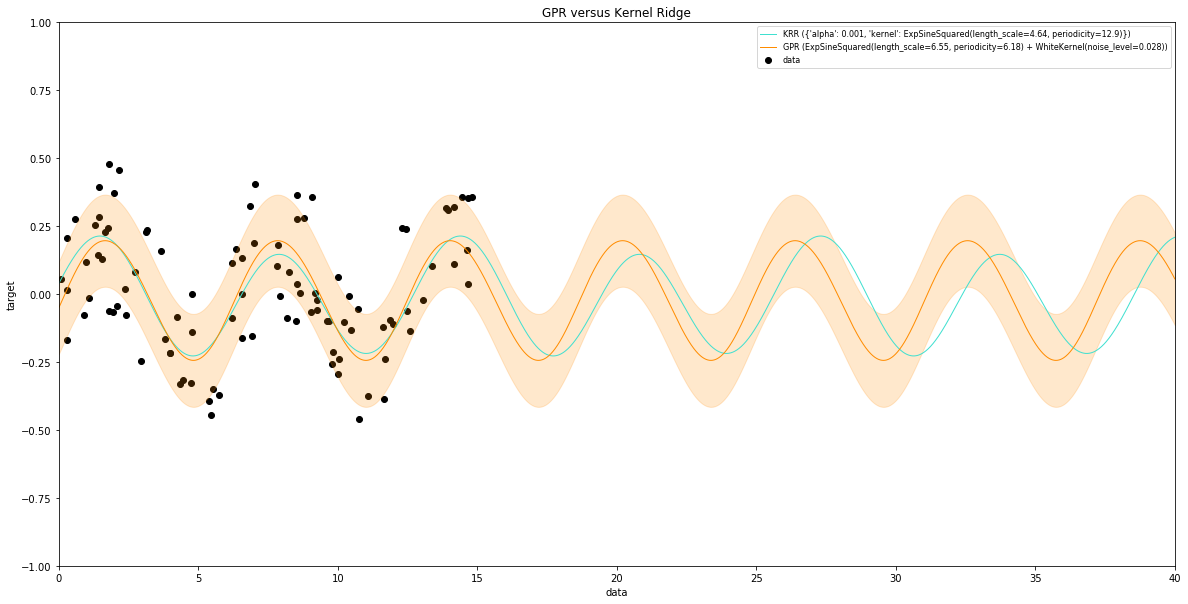

In [1]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause


import time

import numpy as np

import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise
y /= 5

# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 40, 10000)[:, None]
stime = time.time()
y_kr = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using gaussian process regressor
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

# Plot results
plt.figure(figsize=(20, 10))
lw = 1

plt.scatter(X, y, c='k', label='data')
#plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw, label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw, label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange', alpha=0.2)

plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, max(X_plot))
plt.ylim(-1, 1)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

Automatically created module for IPython interactive environment


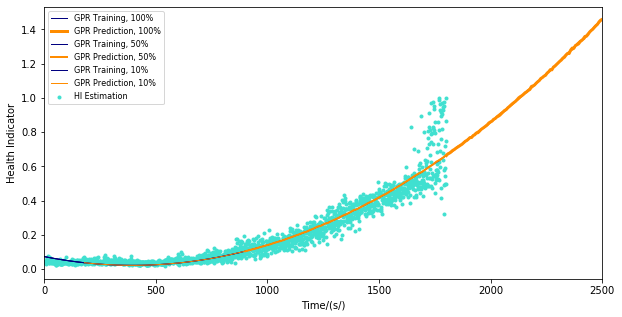

In [2]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


# Generate data
csv_pd = pd.read_csv('../datasets/phm-2012-hi/HI_values_1_3.csv', header=None)
y = csv_pd[0]
X = np.reshape(csv_pd.index.values.tolist(), (-1, 1))
X_boundry = len(X)

X_train_10 = np.linspace(0, X_boundry, 100).reshape(-1, 1)
X_predict_10 = np.linspace(X_boundry, 2500, 100).reshape(-1, 1)

X_train_05 = np.linspace(0, X_boundry*0.5, 100).reshape(-1, 1)
X_predict_05 = np.linspace(X_boundry*0.5, 2500, 100).reshape(-1, 1)

X_train_01 = np.linspace(0, X_boundry*0.1, 100).reshape(-1, 1)
X_predict_01 = np.linspace(X_boundry*0.1, 2500, 100).reshape(-1, 1)

# kernels = [ConstantKernel(0.1, (0.1, 10.0))
#                * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
#            ConstantKernel(0.1, (0.001, 10.0))
#                * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)]

kernels = [
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)]


for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

    # Fit GP
    gp.fit(X, y)

    # GPR Predict result
    y_train_10 = gp.predict(X_train_10)
    y_predict_10 = gp.predict(X_predict_10)
    
    y_train_05 = gp.predict(X_train_05)
    y_predict_05 = gp.predict(X_predict_05)
    
    y_train_01 = gp.predict(X_train_01)
    y_predict_01 = gp.predict(X_predict_01)
    
    # Plot prior
    plt.figure(figsize=(10, 5))
    
    plt.scatter(X, y, color='turquoise', marker='.', label='HI Estimation')
    
    plt.plot(X_train_10, y_train_10, color='navy', lw=1, label='GPR Training, 100%')
    plt.plot(X_predict_10, y_predict_10, color='darkorange', lw=3, label='GPR Prediction, 100%')
    
    plt.plot(X_train_05, y_train_05, color='navy', lw=1, label='GPR Training, 50%')
    plt.plot(X_predict_05, y_predict_05, color='darkorange', lw=2, label='GPR Prediction, 50%')
    
    plt.plot(X_train_01, y_train_01, color='navy', lw=1, label='GPR Training, 10%')
    plt.plot(X_predict_01, y_predict_01, color='darkorange', lw=1, label='GPR Prediction, 10%')
    
    plt.xlabel('Time/(s/)')
    plt.ylabel('Health Indicator')
    plt.xlim(0, max(X_predict_10))
    plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
#     plt.title("Bearing 1_3 PGR result\n (kernel: %s)\n Log-Likelihood: %.3f"
#               % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
#               fontsize=12)
#     plt.tight_layout()
    
    plt.savefig('bearing_pgr_1_3.png', dpi=300)

plt.show()

In [3]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}

kr = GridSearchCV(GaussianProcessRegressor(), 
                  cv=5, 
                  param_grid=param_grid,
                  verbose=1)

stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))



Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scal

Time for KRR fitting: 39599.011


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.1min finished


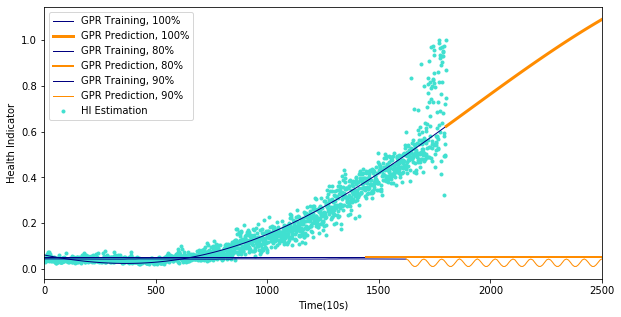

In [14]:

X_train_10 = np.linspace(0, X_boundry, 100).reshape(-1, 1)
X_predict_10 = np.linspace(X_boundry, 2500, 100).reshape(-1, 1)

X_train_05 = np.linspace(0, X_boundry*0.8, 100).reshape(-1, 1)
X_predict_05 = np.linspace(X_boundry*0.8, 2500, 100).reshape(-1, 1)

X_train_01 = np.linspace(0, X_boundry*0.9, 100).reshape(-1, 1)
X_predict_01 = np.linspace(X_boundry*0.9, 2500, 100).reshape(-1, 1)

kr.fit(X_train_10, y_train_10)
y_train_10 = kr.predict(X_train_10)
y_predict_10 = kr.predict(X_predict_10)

kr.fit(X_train_05, y_train_05)
y_train_05 = kr.predict(X_train_05)
y_predict_05 = kr.predict(X_predict_05)

kr.fit(X_train_01, y_train_01)
y_train_01 = kr.predict(X_train_01)
y_predict_01 = kr.predict(X_predict_01)
    
# Plot prior
plt.figure(figsize=(10, 5))
    
plt.scatter(X, y, color='turquoise', marker='.', label='HI Estimation')
plt.plot(X_train_10, y_train_10, color='navy', lw=1, label='GPR Training, 100%')
plt.plot(X_predict_10, y_predict_10, color='darkorange', lw=3, label='GPR Prediction, 100%')
    
plt.plot(X_train_05, y_train_05, color='navy', lw=1, label='GPR Training, 80%')
plt.plot(X_predict_05, y_predict_05, color='darkorange', lw=2, label='GPR Prediction, 80%')
    
plt.plot(X_train_01, y_train_01, color='navy', lw=1, label='GPR Training, 90%')
plt.plot(X_predict_01, y_predict_01, color='darkorange', lw=1, label='GPR Prediction, 90%')
    
plt.xlabel('Time(10s)')
plt.ylabel('Health Indicator')
plt.xlim(0, max(X_predict))
plt.legend(loc="best",  scatterpoints=1, prop={'size': 10})
plt.savefig('gpr.png', dpi=300)